In [1]:
#import io
#import json
import uuid

from datasets import load_dataset
from sklearn.metrics import accuracy_score, f1_score
import torch
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers.tokenization_utils_base import BatchEncoding
from transformers import Trainer, TrainingArguments

from utils import get_object, put_file, get_object_list, put_text, get_text

#### Set up the Device

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
device

device(type='cuda')

#### Load the Data

In [3]:
emotions = load_dataset('emotion')
type(emotions)

datasets.dataset_dict.DatasetDict

In [4]:
dataset_bucket_name = 'emotions-data'
for split, dataset in emotions.items():
    dataset.to_json(f'emotions-{split}.jsonl')
    object_write_results = put_file(dataset_bucket_name, f'emotions-{split}.jsonl', f'emotions-{split}.jsonl')
    print(object_write_results.object_name, object_write_results.location)

Creating json from Arrow format:   0%|          | 0/16 [00:00<?, ?ba/s]

emotions-train.jsonl None


Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

emotions-validation.jsonl None


Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

emotions-test.jsonl None


In [5]:
data_files = {}
for split in ['train', 'validation', 'test']:
    data_files[split] = f'emotions-{split}.jsonl'
    object_info = get_object(dataset_bucket_name, f'emotions-{split}.jsonl', f'emotions-{split}.jsonl')
    print(object_info.object_name, object_info.last_modified)

emotions = load_dataset('json', data_files=data_files)

emotions-train.jsonl 2023-10-02 18:55:26+00:00
emotions-validation.jsonl 2023-10-02 18:55:27+00:00
emotions-test.jsonl 2023-10-02 18:55:27+00:00


Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

#### Load MinIO bucket for batch-inference

In [6]:
batch_data_bucket_name = 'batch-inference'
count = 0

json_list = []
with open('emotions-test.jsonl', 'r') as json_file:
    json_list = list(json_file)

for json_str in json_list:
    object_name = f'{uuid.uuid4()}.json'
    put_text(batch_data_bucket_name, object_name, json_str)
    count += 1
    #json_dict = json.loads(json_str)
    #print(f"result: {json_dict}")
    #print(isinstance(json_dict, dict))

print(f'{count} objects uploaded.')

2000 objects uploaded.


#### Encoding experiments

In [7]:
import io
text = 'hello'
# Upload the dataframe as an object.
#encoded_df = df.to_csv(index=False).encode('utf-8')
#client.put_object(bucket, object_name, data=io.BytesIO(encoded_df), length=len(encoded_df), content_type='application/csv')

text_as_bytes = str.encode(text)
text_bytes_io = io.BytesIO(text_as_bytes)
print(len(text_as_bytes))

5


#### Load the model

In [8]:
model_check_point = 'distilbert-base-uncased'
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_check_point, num_labels=num_labels).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_check_point)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#### Tokenize the entire Dataset

In [9]:
emotions.reset_format()
def tokenize(batch) -> BatchEncoding:
    out = tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt')
    return out

emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

#### Create a Metrics function

In [10]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    accuracy = accuracy_score(labels, preds)
    return {'accuracy': accuracy, 'f1': f1}

#### Training Arguments

In [11]:
batch_size = 64
logging_steps = len(emotions_encoded['train']) // batch_size
model_name = f'{model_check_point}-finetuned-emotion'

training_args = TrainingArguments(output_dir=model_name, 
                                  num_train_epochs=2, 
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level='error')

In [12]:
trainer = Trainer(model=model, 
                  args=training_args, 
                  compute_metrics=compute_metrics, 
                  train_dataset=emotions_encoded['train'],
                  eval_dataset=emotions_encoded['validation'],
                  tokenizer=tokenizer)
trainer.train()

  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 0.8604, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.3318408727645874, 'eval_accuracy': 0.907, 'eval_f1': 0.9058079071979159, 'eval_runtime': 2.2416, 'eval_samples_per_second': 892.218, 'eval_steps_per_second': 111.527, 'epoch': 1.0}
{'loss': 0.2664, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/250 [00:00<?, ?it/s]

{'eval_loss': 0.22635775804519653, 'eval_accuracy': 0.9255, 'eval_f1': 0.925372878895474, 'eval_runtime': 2.3919, 'eval_samples_per_second': 836.154, 'eval_steps_per_second': 104.519, 'epoch': 2.0}
{'train_runtime': 111.5211, 'train_samples_per_second': 286.941, 'train_steps_per_second': 4.483, 'train_loss': 0.5633893585205079, 'epoch': 2.0}


TrainOutput(global_step=500, training_loss=0.5633893585205079, metrics={'train_runtime': 111.5211, 'train_samples_per_second': 286.941, 'train_steps_per_second': 4.483, 'train_loss': 0.5633893585205079, 'epoch': 2.0})

In [13]:
def get_new_data(bucket_name: str, file_path: str) -> None:
    object_list = get_object_list(bucket_name)

    json_list = []
    for obj in object_list:
        json_str = get_text(bucket_name, obj)
        json_list.append(json_str)

    with open(file_path, 'w') as f:
        for item in json_list:
            f.write(item)

#len(json_list)

In [14]:
data_file = 'batch_data.jsonl'
get_new_data(batch_data_bucket_name, data_file)
new_data = load_dataset('json', data_files={'batch_data': data_file})
new_data_encoded = new_data.map(tokenize, batched=True, batch_size=None)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating batch_data split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

In [15]:
predictions = trainer.predict(new_data_encoded['batch_data'])
predictions.metrics

  0%|          | 0/500 [00:00<?, ?it/s]

{'test_loss': 0.23394106328487396,
 'test_accuracy': 0.9125,
 'test_f1': 0.9121245466230031,
 'test_runtime': 4.5352,
 'test_samples_per_second': 881.995,
 'test_steps_per_second': 110.249}

In [16]:
import numpy as np
y_predictions = np.argmax(predictions.predictions, axis=1)
y_predictions

array([0, 3, 0, ..., 4, 3, 5], dtype=int64)

In [17]:
y_batch_data = np.array(new_data_encoded['batch_data']['label'])
y_batch_data

array([0, 3, 0, ..., 4, 3, 4])

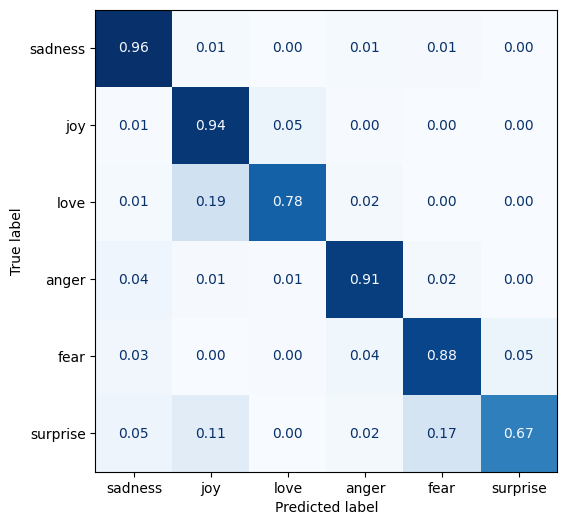

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_predicted, y_true, labels):
    cm = confusion_matrix(y_true, y_predicted, normalize='true')
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title = ('Normalized Confusion Matrix')
    plt.show()

labels = ['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

plot_confusion_matrix(y_predictions, y_batch_data, labels)